In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import copy, deepcopy 

#Pacejka 5.2 (2002) pure logitudinal with IA

params_Indy=[2,      #pCx1 Shape factor Cfx for longitudinal force 
             1.7168,      #pDx1 Longitudinal friction Mux at Fznom
             -0.289,      #pDx2 Variation of friction Mux with load
             0,           #pDx3 Variation of friction Mux with camber
             0.6975,      #pEx1 Longitudinal curvature Efx at Fznom
             0.20123,     #pEx2 Variation of curvature Efx with load
             0,           #pEx3 Variation of curvature Efx with load squared
             0,           #pEx4 Factor in curvature Efx while driving
             -0.00058,    #pHx1 Horizontal shift Shx at Fznom
             -0.00079,    #pHx2 Variation of shift Shx with load
             0, 
             63.75,       #pKx1 Longitudinal slip stiffness Kfx/Fz at Fznom
             -15,         #pKx2 Variation of slip stiffness Kfx/Fz with loa
             0.2891,      #pKx3 Exponent in slip stiffness Kfx/Fz with load
             -0.1,        #pVx1 Vertical shift Svx/Fz at Fznom
             -0.45]        #pVx2 Variation of shift Svx/Fz with load

params_PKW=[1.6,           #pCx1 Shape factor Cfx for longitudinal force
             1.5,           #pDx1 Longitudinal friction Mux at Fznom
             -0.04,         #pDx2 Variation of friction Mux with load
             0.1,           #pDx3 Variation of friction Mux with camber
             0.7,           #pEx1 Longitudinal curvature Efx at Fznom
             -0.17,         #pEx2 Variation of curvature Efx with load
             0.023,         #pEx3 Variation of curvature Efx with load squared
             -0.14,         #pEx4 Factor in curvature Efx while driving
             0,             #pHx1 Horizontal shift Shx at Fznom
             0,             #pHx2 Variation of shift Shx with load
             0, 
             30.7,          #pKx1 Longitudinal slip stiffness Kfx/Fz at Fznom
             0.27,          #pKx2 Variation of slip stiffness Kfx/Fz with load
             0.13,          #pKx3 Exponent in slip stiffness Kfx/Fz with load
             0,             #pVx1 Vertical shift Svx/Fz at Fznom
             0]              #pVx2 Variation of shift Svx/Fz with load

Fz=4000 #N Fz range von Indy 8000-18000 N

i=1000
SL=np.linspace(-1,1,i)
IA=0
Fz0=3114 #nominal load (z.b 80% von Fzmax)
    
def Pacejka5_2(Fz,SL,IA,Fz0,params): 
    #IA=inclination angle,  Fz0= highest load in data, 
    
    #converts to rad
    gamma = IA*np.pi/180
    
    dfz = ((Fz-Fz0)/Fz0)  
    kappa = SL #- Reifengeschw/ Fahrzeuggeschw
    SHx = params[8] + params[9] * dfz
    kappax = kappa + SHx
    Ksr = Fz * (params[11] + params[12] * dfz) * np.exp(params[13] * dfz)   
    C = params_Indy[0] 
    mu = (params[1] + params[2] * dfz) * (1 - params[3] * gamma**2)#gamma=slip ratio
    D = mu*Fz
    B = Ksr / (C * D + 0.001)  #e=0.001
    E = (params[4] + params[5] * dfz ) * (1 - (params[7] * np.sign(kappax))) #+ params[6] ** dfz therm fehlt
    Sv = Fz * (params[14] + params[15] * dfz) 
   
    
    FX= D * np.sin(C * np.arctan(B * kappax - E * (B*kappax - np.arctan(B * kappax)))) 
    
    return FX,D,B,C,Ksr,E

def Pacejka5(D,B,C,E,kappax):
    FX= D * np.sin(C * np.arctan(B * kappax - E * (B*kappax - np.arctan(B * kappax))))
    return FX

a = Pacejka5_2(Fz,SL,IA,Fz0,params_Indy)

import numpy as np
import scipy.io
scipy.io.savemat('test.mat', dict(SL=SL, Fx=Pacejka5_2(Fz,SL,IA,Fz0,params_Indy)[0]))
#print(Pacejka5_2(4000,SL,IA,Fz0,params_Indy)[4])
#plt.plot(SL,Pacejka5_2(4000,SL,IA,Fz0,params_PKW)[0])

500


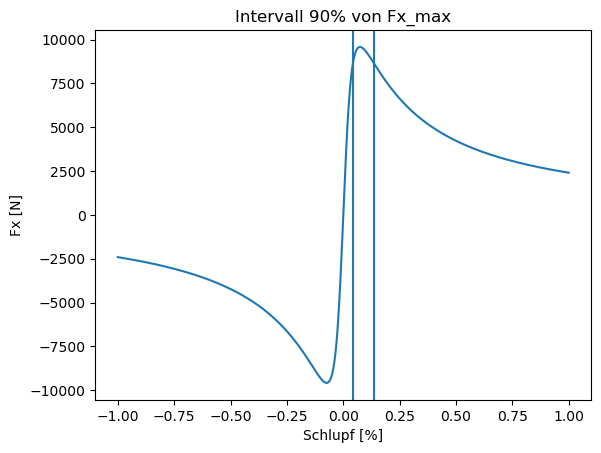

In [10]:
#Vergleichsgrößen

def Fx_intervall(Fz,Fx_intv,params): #Fz in [kN], Fx_intv in % (z.b 10% von Fx_max)
#x Position von Fx_max berechnene
    Fx_w=Pacejka5_2(Fz,SL,IA,Fz0,params)[0]
    w=len(Fx_w)
    Fx_max_pos=0
    for j in range(0,w):
        if Fx_w[j] == np.max(Pacejka5_2(Fz,SL,IA,Fz0,params)[0]):
            break
        else:
            Fx_max_pos = Fx_max_pos + 1

    #cut slop
    cut = int(w/2)
    Fx_w_pos = Fx_w[cut::]
    Fx_w_pos_max=Fx_w_pos[0:((Fx_max_pos-cut)+1)] #von 0 bis Fx_max
    Fx_w_max_end=Fx_w_pos[((Fx_max_pos-cut)+1)::] #von Fx_max bis Ende(+100% slipratio)

    Fx_max_ref = np.max(Pacejka5_2(Fz,SL,IA,Fz0,params)[0]) * Fx_intv #Referenzwert Fx 10% weniger als Fx_max

    left=0
    j=0
    for j in range(0,len(Fx_w_pos_max)):
        if Fx_w_pos_max[j] < Fx_max_ref:
            left +=1
        else:
            break
        
    right = 0
    j=0
    for j in range(0,len(Fx_w_max_end)):
        if Fx_w_max_end[j] > Fx_max_ref:
            right +=1
        else:
            break
        
#Intervall 10% abweichung von Fx_max = [left,right]
    Fx_max_10=Fx_w[cut+left:cut+len(Fx_w_pos_max)+right]
    Fx_slope_b=((len(Fx_w_pos_max)+right)-left)/(cut/100) #breite des Intervalls in %Schlupf
    
    return Fx_slope_b,Fx_max_10,cut,left,right,Fx_w_pos_max

#plot für datstellung Intervall
Fz = 5000
plt.figure(1)
Fx = Pacejka5_2(Fz,SL,IA,Fz0,params_Indy)[0]
cut = Pacejka5_2(Fz,SL,IA,Fz0,params_Indy)[2]
plt.plot(SL,Fx)
plt.xlabel('Schlupf [%]')
plt.ylabel('Fx [N]')
print(Fx_intervall(Fz,0.9,params_Indy)[2])
a = Fx_intervall(Fz,0.9,params_Indy)[3]
b = len(Fx_intervall(Fz,0.9,params_Indy)[5])
plt.axvline(0.042)
plt.axvline(0.138)
plt.title('Intervall 90% von Fx_max')




steps=11
Fz_arr1=np.linspace(8000,18000,steps) #von 1kN bis 10kN Fz
Fz_arr=np.round(Fz_arr1,5)

Fx_max_arr = np.zeros((steps,))
Start_slope = np.zeros((steps,))
Dx_max = np.zeros((steps,))
Fx_intv_arr = np.zeros((steps,))
Fx_max_slip_arr = np.zeros((steps,))

plt.figure
i=0

for i in range(1,steps):
    #plt.plot(SL,Pacejka5_2(Fz_arr[int(i)],SL,IA,Fz0,params_Indy)[0],label="Fz={}N".format(Fz_arr[i]))
    #plt.legend(loc = "upper left")
    
    Fx_max_arr[i] = np.max(Pacejka5_2(Fz_arr[int(i)],SL,IA,Fz0,params_Indy)[0]) #numerischer Maximalert
    Fx_max_slip_arr[i] = np.argmax(Pacejka5_2(Fz_arr[int(i)],SL,IA,Fz0,params_Indy)[0]) #slipwert bei Fx_max
    Start_slope[i] = np.arctan(Pacejka5_2(Fz_arr[int(i)],SL,IA,Fz0,params_Indy)[1] * 
                               Pacejka5_2(Fz_arr[int(i)],SL,IA,Fz0,params_Indy)[2] * 
                               Pacejka5_2(Fz_arr[int(i)],SL,IA,Fz0,params_Indy)[3]) #Anfangssteigung
    Dx_max[i] = Pacejka5_2(Fz_arr[int(i)],SL,IA,Fz0,params_Indy)[1] #maximalWert aus Modell
    Fx_intv_arr[i] = Fx_intervall(Fz_arr[i],0.9,params_Indy)[0] #Intervall mit >= 90%Fx_max


#Schräglaufsteifigkeit [N/rad]

#Fomrel aus pacejka Buch
def slope(Fz,params):
    slope = Pacejka5_2(Fz,SL,IA,Fz0,params)[1] * Pacejka5_2(Fz,SL,IA,Fz0,params)[2] * Pacejka5_2(Fz,SL,IA,Fz0,params)[3]
    return slope


#Schräglaufsteifkeit über ableiten
#ableiten
def diff_Pacejka(y,SL): #y = Funktion die abgleitet werden soll, Sl = linspace
    dx = SL[1]-SL[0]
    dydx = np.gradient(y, dx)
    return dydx

#Schräglaufsteifkeit über ableiten

i = len(SL)/2

err = diff_Pacejka(Pacejka5_2(Fz,SL,IA,Fz0,params_Indy)[0],SL)[int(i)] - slope(Fz,params_Indy)
#print(err)

#plt.plot(SL,Pacejka5_2(4000,SL,IA,Fz0,params)[0],'g')
#plt.plot(SL,diff_Pacejka(Pacejka5_2(4000,SL,IA,Fz0,params)[0],SL))
#plt.xlim(-1,1)
#plt.ylim(-15000,15000)

In [11]:
#größen für lokale SA

s = 0.1 #10% änderung
params_SA = deepcopy(params_Indy)
Fz = 10000 #[N]

Text(0.5, 1.0, 'lokale SA Fx_max, Parameter -10% ')

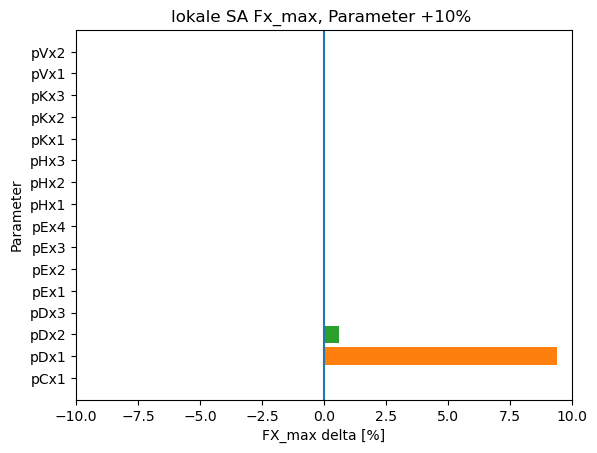

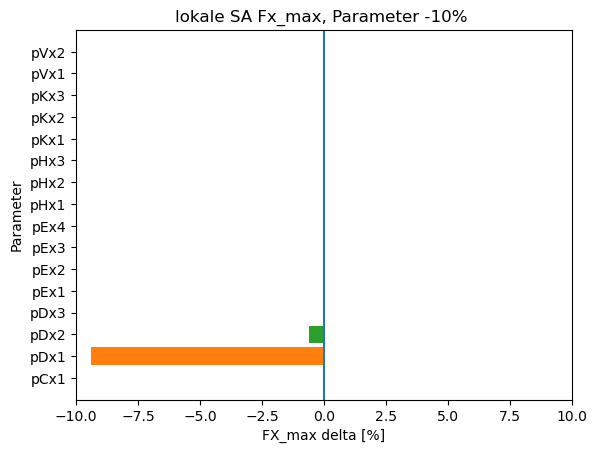

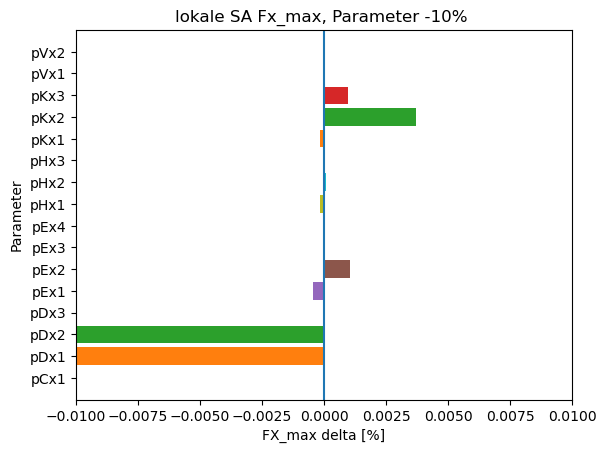

In [12]:
### lokale Sensitivität

#Fx_max, IA = 0.1°
i=0
pramas_Set=params_SA
params=np.zeros((len(pramas_Set),))

for i in range(0,len(pramas_Set)):
    params[i]=params_Indy[i]
    
params_pos = pramas_Set
params_neg = pramas_Set
i=0

delta=np.zeros((len(params),2))

for i in range(0,len(params)):
    
    params_pos[i] = params_pos[i]*(1+s)
    delta_Fx_max_pos = (np.max(Pacejka5_2(Fz,SL,IA,Fz0,params)[0]) - np.max(Pacejka5_2(Fz,SL,IA,Fz0,params_pos)[0]))/np.max(Pacejka5_2(Fz,SL,IA,Fz0,params)[0])
    params_pos[i] = params[i]
    
    params_neg[i] = params_neg[i]*(1-s)
    delta_Fx_max_neg = (np.max(Pacejka5_2(Fz,SL,IA,Fz0,params)[0]) - np.max(Pacejka5_2(Fz,SL,IA,Fz0,params_neg)[0]))/np.max(Pacejka5_2(Fz,SL,IA,Fz0,params)[0])
    params_neg[i] = params[i]
    
    delta[i] = [delta_Fx_max_neg*100, delta_Fx_max_pos*100]
    
i=0
delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(params)):
    delta_pos[i,0] = 0

i=0
for i in range(0,len(params)):
    delta_neg[i,1] = 0


#Plots params -10%
fig, ax = plt.subplots()
y_axis=('pCx1','pDx1', 'pDx2', 'pDx3','pEx1', 'pEx2', 'pEx3', 'pEx4', 'pHx1', 'pHx2', 'pHx3','pKx1', 'pKx2', 'pKx3','pVx1', 'pVx2')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_neg[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-10,10)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("FX_max delta [%]")
plt.ylabel("Parameter")
plt.title('lokale SA Fx_max, Parameter +10% ')

#Plots params +10%
fig, ax = plt.subplots()
#print(delta_neg)
y_axis=('pCx1','pDx1', 'pDx2', 'pDx3','pEx1', 'pEx2', 'pEx3', 'pEx4', 'pHx1', 'pHx2', 'pHx3','pKx1', 'pKx2', 'pKx3','pVx1', 'pVx2')
y_pos=np.arange(len(y_axis))

i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_pos[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-10,10)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("FX_max delta [%]")
plt.ylabel("Parameter")
plt.title('lokale SA Fx_max, Parameter -10% ')

#Plots params +10%
fig, ax = plt.subplots()
#print(delta_neg)
y_axis=('pCx1','pDx1', 'pDx2', 'pDx3','pEx1', 'pEx2', 'pEx3', 'pEx4', 'pHx1', 'pHx2', 'pHx3','pKx1', 'pKx2', 'pKx3','pVx1', 'pVx2')
y_pos=np.arange(len(y_axis))

i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_pos[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-0.01,0.01)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("FX_max delta [%]")
plt.ylabel("Parameter")
plt.title('lokale SA Fx_max, Parameter -10% ')



Text(0.5, 1.0, 'lokale SA,Slip bei Fx_max, Parameter -10% ')

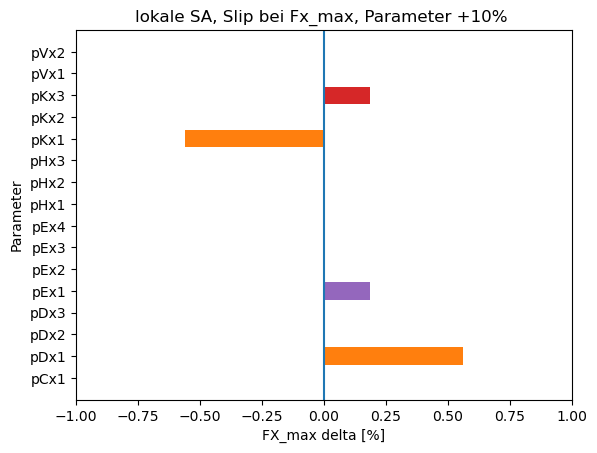

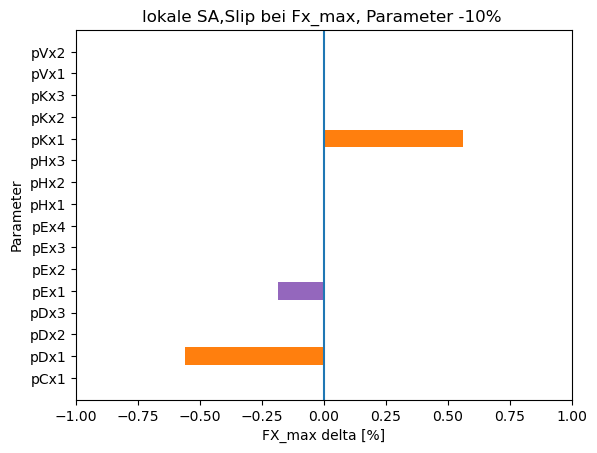

In [13]:
#Sl bei max Fx

#Fx_max#Fz = 4000N, IA = 0.1°
i=0
pramas_Set=params_SA


params=np.zeros((len(pramas_Set),))

for i in range(0,len(pramas_Set)):
    params[i]=params_Indy[i]
    
params_pos = pramas_Set
params_neg = pramas_Set
i=0

delta=np.zeros((len(params),2))

for i in range(0,len(params)):
    
    params_pos[i] = params_pos[i]*(1+s)
    delta_pos = (np.argmax(Pacejka5_2(Fz,SL,IA,Fz0,params)[0]) - np.argmax(Pacejka5_2(Fz,SL,IA,Fz0,params_pos)[0]))/(np.argmax(Pacejka5_2(Fz,SL,IA,Fz0,params)[0]))
    params_pos[i] = params[i]
   
    params_neg[i] = params_neg[i]*(1-s)
    delta_neg = (np.argmax(Pacejka5_2(Fz,SL,IA,Fz0,params)[0]) - np.argmax(Pacejka5_2(Fz,SL,IA,Fz0,params_neg)[0]))/(np.argmax(Pacejka5_2(Fz,SL,IA,Fz0,params)[0]))
    params_neg[i] = params[i]
    
    delta[i] = [delta_neg*100, delta_pos*100]
    
i=0
delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(params)):
    delta_pos[i,0] = 0

i=0
for i in range(0,len(params)):
    delta_neg[i,1] = 0

#Plots params -10%
fig, ax = plt.subplots()
y_axis=('pCx1','pDx1', 'pDx2', 'pDx3','pEx1', 'pEx2', 'pEx3', 'pEx4', 'pHx1', 'pHx2', 'pHx3','pKx1', 'pKx2', 'pKx3','pVx1', 'pVx2')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_neg[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-1,1)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("FX_max delta [%]")
plt.ylabel("Parameter")
plt.title('lokale SA, Slip bei Fx_max, Parameter +10% ')

#Plots params +10%
fig, ax = plt.subplots()
#print(delta_neg)
y_axis=('pCx1','pDx1', 'pDx2', 'pDx3','pEx1', 'pEx2', 'pEx3', 'pEx4', 'pHx1', 'pHx2', 'pHx3','pKx1', 'pKx2', 'pKx3','pVx1', 'pVx2')
y_pos=np.arange(len(y_axis))

i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_pos[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-1,1)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("FX_max delta [%]")
plt.ylabel("Parameter")
plt.title('lokale SA,Slip bei Fx_max, Parameter -10% ')


Text(0.5, 1.0, 'lokale SA, Slip Intervall (90% von Fx max), Parameter +10% ')

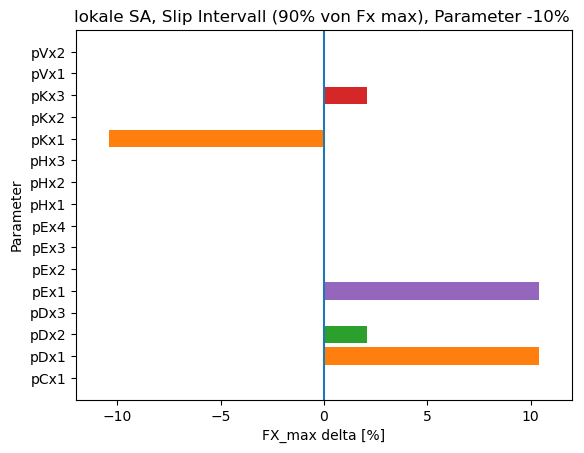

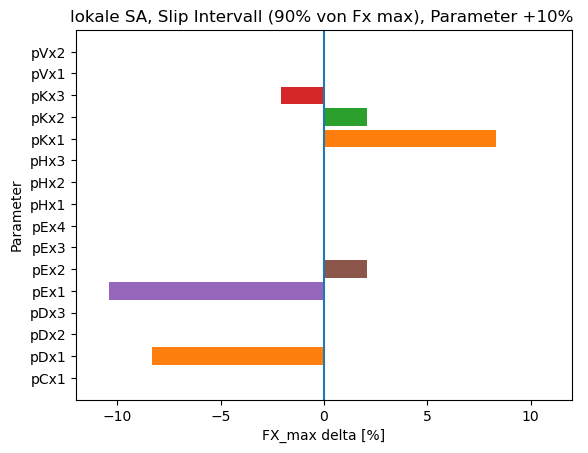

In [14]:
#Slip Intervall (10% von Fx max)

#Fx_max, IA = 0.1°
i=0


pramas_Set=params_SA


params=np.zeros((len(pramas_Set),))

for i in range(0,len(pramas_Set)):
    params[i]=params_Indy[i]
    
params_pos = deepcopy(pramas_Set)
params_neg = deepcopy(pramas_Set)
i=0

delta=np.zeros((len(params),2))

for i in range(0,len(params)):
    
    params_pos[i] = params_pos[i]*(1+s)
    delta_pos = (Fx_intervall(Fz,0.9,params)[0] - Fx_intervall(Fz,0.9,params_pos)[0])/(Fx_intervall(Fz,0.9,params)[0])
    params_pos[i] = params[i]

    params_neg[i] = params_neg[i]*(1-s)
    delta_neg = (Fx_intervall(Fz,0.9,params)[0] - Fx_intervall(Fz,0.9,params_neg)[0])/(Fx_intervall(Fz,0.9,params)[0])
    params_neg[i] = params[i]
    
    delta[i] = [delta_neg*100, delta_pos*100]
    
i=0
delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(params)):
    delta_pos[i,0] = 0

i=0
for i in range(0,len(params)):
    delta_neg[i,1] = 0


#Plots params -10%
fig, ax = plt.subplots()
y_axis=('pCx1','pDx1', 'pDx2', 'pDx3','pEx1', 'pEx2', 'pEx3', 'pEx4', 'pHx1', 'pHx2', 'pHx3','pKx1', 'pKx2', 'pKx3','pVx1', 'pVx2')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_neg[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-12,12)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("FX_max delta [%]")
plt.ylabel("Parameter")
plt.title('lokale SA, Slip Intervall (90% von Fx max), Parameter -10% ')

#Plots params +10%
fig, ax = plt.subplots()
#print(delta_neg)
y_axis=('pCx1','pDx1', 'pDx2', 'pDx3','pEx1', 'pEx2', 'pEx3', 'pEx4', 'pHx1', 'pHx2', 'pHx3','pKx1', 'pKx2', 'pKx3','pVx1', 'pVx2')
y_pos=np.arange(len(y_axis))

i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_pos[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-12,12)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("FX_max delta [%]")
plt.ylabel("Parameter")
plt.title('lokale SA, Slip Intervall (90% von Fx max), Parameter +10% ')

Text(0.5, 1.0, 'lokale SA, Fz (10% von Fz ref), Parameter +10% ')

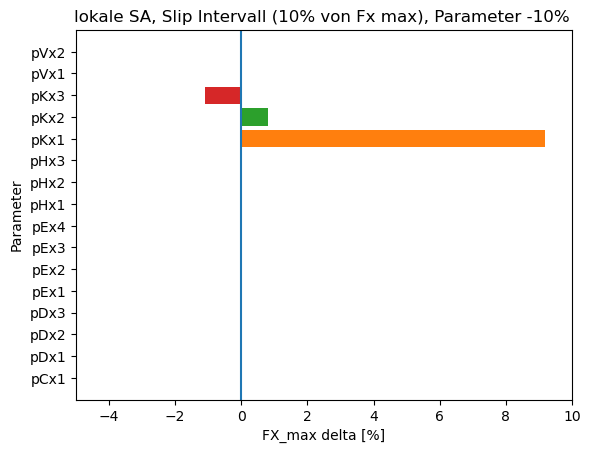

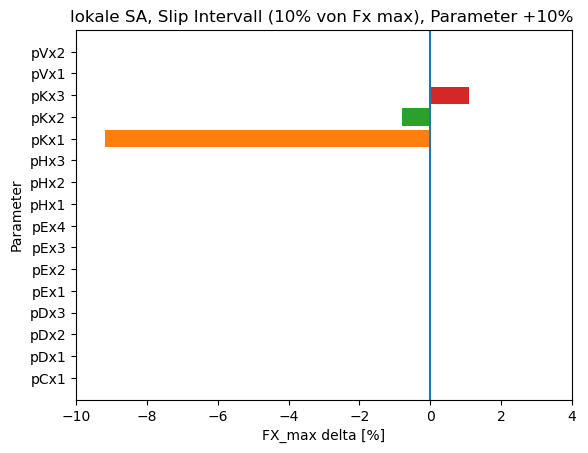

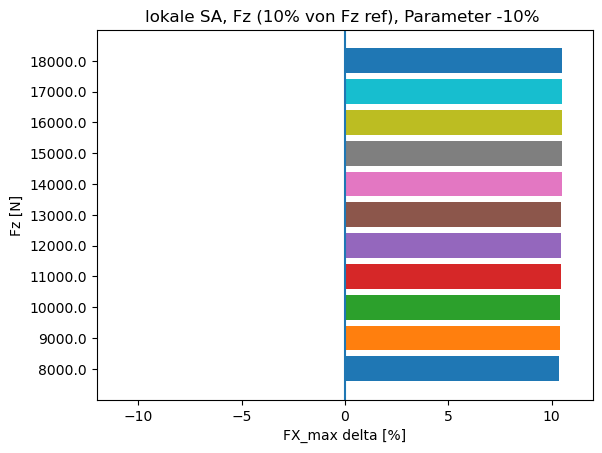

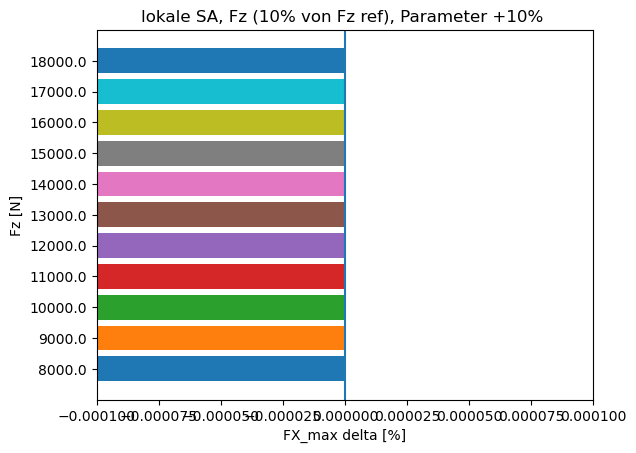

In [15]:
#Schräglaufsteifigkeit 


#Fx_max#Fz = 4000N, IA = 0.1°
i=0

pramas_Set=params_SA


params=np.zeros((len(pramas_Set),))

for i in range(0,len(pramas_Set)):
    params[i]=params_Indy[i]
    
params_pos = pramas_Set
params_neg = pramas_Set
i=0

delta=np.zeros((len(params),2))


for i in range(0,len(params)):
    
    params_pos[i] = params_pos[i]*(1+s)
    delta_pos = (slope(Fz,params) - slope(Fz,params_pos))/(slope(Fz,params))
    params_pos[i] = params[i]

    params_neg[i] = params_neg[i]*(1-s)
    delta_neg = (slope(Fz,params) - slope(Fz,params_neg))/(slope(Fz,params))
    params_neg[i] = params[i]
    
    delta[i] = [delta_neg*100, delta_pos*100]
    
i=0
delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(params)):
    delta_pos[i,0] = 0

i=0
for i in range(0,len(params)):
    delta_neg[i,1] = 0



#Plots params -10%
fig, ax = plt.subplots()
y_axis=('pCx1','pDx1', 'pDx2', 'pDx3','pEx1', 'pEx2', 'pEx3', 'pEx4', 'pHx1', 'pHx2', 'pHx3','pKx1', 'pKx2', 'pKx3','pVx1', 'pVx2')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_neg[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-5,10)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("FX_max delta [%]")
plt.ylabel("Parameter")
plt.title('lokale SA, Slip Intervall (10% von Fx max), Parameter -10% ')

#Plots params +10%
fig, ax = plt.subplots()
#print(delta_neg)
y_axis=('pCx1','pDx1', 'pDx2', 'pDx3','pEx1', 'pEx2', 'pEx3', 'pEx4', 'pHx1', 'pHx2', 'pHx3','pKx1', 'pKx2', 'pKx3','pVx1', 'pVx2')
y_pos=np.arange(len(y_axis))

i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_pos[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-10,4)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("FX_max delta [%]")
plt.ylabel("Parameter")
plt.title('lokale SA, Slip Intervall (10% von Fx max), Parameter +10% ')

#--> Schräglaufsteifigkeit sehr wenig von einzelnen parametern abhängig
#Vorzeichen überprüfen !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#Lokale SA Schräglaufsteifigkeit Fz, abhängig

Fz_arr = np.linspace(8000,18000,11)
Fz_arr_pos = deepcopy(Fz_arr)
Fz_arr_neg = deepcopy(Fz_arr)
delta=np.zeros((len(Fz_arr),2))
delta_neg = 0
delta_pos = 0

i=0
for i in range(0,len(Fz_arr)):
    
    Fz_arr_pos[i] = Fz_arr[i]*(1+s)
    delta_pos = (slope(Fz_arr[i],params_Indy) - slope(Fz_arr_pos[i],params_Indy))/(slope(Fz_arr[i],params_Indy))
    Fz_arr_pos[i] = Fz_arr[i]
    

    Fz_arr_neg[i] = Fz_arr[i]*(1-s)
    delta_neg = (slope(Fz_arr[i],params_Indy) - slope(Fz_arr_neg[i],params_Indy))/(slope(Fz_arr[i],params_Indy))
    Fz_arr_neg[i] = Fz_arr[i]
    
        
    delta[i] = [delta_neg*100, delta_pos*100]

i=0
delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(Fz_arr)):
    delta_pos[i,0] = 0

i=0
for i in range(0,len(Fz_arr)):
    delta_neg[i,1] = 0



#Plots params -10%
fig, ax = plt.subplots()
y_axis=Fz_arr
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_neg[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-12,12)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("FX_max delta [%]")
plt.ylabel("Fz [N]")
plt.title('lokale SA, Fz (10% von Fz ref), Parameter -10% ')

#Plots params +10%
fig, ax = plt.subplots()
#print(delta_neg)
y_axis=Fz_arr
y_pos=np.arange(len(y_axis))

i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_pos[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-0.0001,0.0001)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("FX_max delta [%]")
plt.ylabel("Fz [N]")
plt.title('lokale SA, Fz (10% von Fz ref), Parameter +10% ')